In [15]:
from pathlib import Path
from tqdm import tqdm
import nibabel as nib
import numpy as np
import pandas as pd
import shutil
import pickle

from sklearn import tree

from brats21 import utils as bu
from brats21.postprocessing import (
    logits_to_classes,
    revert_bbox_softmax,
    classes_transformations,
)

import matplotlib.pyplot as plt
import plotly.express as px

## Basic definitions

In [3]:
def plot_masks(vol):
    return px.imshow(vol, facet_col=0, animation_frame=1, binary_string=True)

In [5]:
class SuspectLoader:
    """Loade and process logits from a directory as returned from nnUNet."""

    def __init__(self, input_dir):
        self.input_dir = Path(input_dir)

        self.logits = {x.stem: x for x in self.input_dir.glob("*.npz")}
        assert len(self.logits) > 0, f"No softmax found in {self.input_dir}"

    def __len__(self):
        return len(self.logits)

    def __getitem__(self, idx):
        path = self.logits[idx]

        logit = np.load(path)["softmax"]
        logit_id = path.name.split(".")[0]

        # Load meta information
        meta = bu.load_pickle(path.with_suffix(".pkl"))
        bbox = meta["crop_bbox"]
        shape = np.insert(meta["original_size_of_raw_data"], 0, 3)

        # Logits to classes
        classes = revert_bbox_softmax(logit, bbox, shape)

        return classes

    def get_id(self, idx):
        return self.logits[idx].stem


In [8]:
def predicted_num_voxels(vol, **kwargs):
    classes = logits_to_classes(vol, **kwargs)
    return [np.sum(classes == i) for i in range(1, 4)]

In [4]:
TARGET = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/NewPredictions/TrainerBratsRegions")
tumor_presence_path = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/tumor_presence.csv")

In [6]:
loader = SuspectLoader(TARGET)

In [7]:
tumor_presence = pd.read_csv(tumor_presence_path)
tumor_presence.loc[:, "scan_id"] = tumor_presence.scan_id.map(lambda x: f"{x:05}")
tumor_presence.set_index("scan_id", inplace=True)

## Compute volumes

In [9]:
edema = 0.475
enhancing = 0.681
necrotic = 0.449

tumor_presence["old_ET"] = None
tumor_presence["old_TC"] = None
tumor_presence["old_WT"] = None

tumor_presence["new_ET"] = None
tumor_presence["new_TC"] = None
tumor_presence["new_WT"] = None

for sid, _ in tqdm(list(tumor_presence.iterrows())):
    volume = loader[sid]
    
    ed, ne, en = predicted_num_voxels(volume, thresholds=(0.5, 0.5, 0.5))
    tumor_presence.loc[sid, "old_WT"] = ed
    tumor_presence.loc[sid, "old_TC"] = ne
    tumor_presence.loc[sid, "old_ET"] = en
    
    ed, ne, en = predicted_num_voxels(volume, thresholds=(edema, necrotic, enhancing))
    tumor_presence.loc[sid, "new_WT"] = ed
    tumor_presence.loc[sid, "new_TC"] = ne
    tumor_presence.loc[sid, "new_ET"] = en


100%|██████████| 219/219 [00:55<00:00,  3.93it/s]


In [11]:
tumor_presence

,contains_ET,contains_TC,contains_WT,old_ET,old_TC,old_WT,new_ET,new_TC,new_WT
scan_id,,,,,,,,,
00001,yes,yes,yes,22749,17922,86622,21959,18763,86857
00013,yes,yes,yes,42836,25682,41686,41476,27181,42105
00015,yes,yes,yes,32602,11045,177933,31849,11856,178397
00027,yes,yes,yes,20823,13861,26689,20080,14658,26913
00037,yes,yes,yes,6270,857,39911,6176,937,40042
...,...,...,...,...,...,...,...,...,...
01794,yes,yes,yes,9396,720,20470,9321,806,20534
01795,yes,yes,yes,16161,3288,46706,15865,3679,46712
01796,yes,yes,yes,3411,128,62058,3348,199,62356


## Decision tree

In [12]:
tree_clf = tree.DecisionTreeClassifier(max_depth=2)
tree_clf = tree_clf.fit(tumor_presence.loc[tumor_presence["new_ET"] != 0, ["new_ET", "new_TC", "new_WT"]], tumor_presence.contains_ET[tumor_presence["new_ET"] != 0])

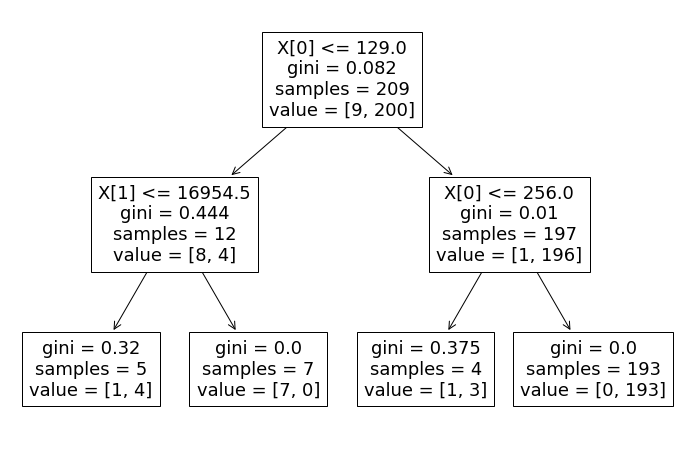

In [13]:
plt.figure(figsize=(12, 8))
tree.plot_tree(tree_clf);

In [12]:
def use_dt_thresholds(sample):
    if sample[0] <= 129.5 and sample[1] > 16954.0:
        return True
    return False

In [13]:
preds = tumor_presence.copy()
preds["remove"] = None
for iid, row in preds.iterrows():
    preds.loc[iid, "remove"] = use_dt_thresholds(row[6:8]) 
    
preds[(preds.contains_ET == "no") | (preds.remove == True)]

,contains_ET,contains_TC,contains_WT,old_ET,old_TC,old_WT,new_ET,new_TC,new_WT,remove
scan_id,,,,,,,,,,
00163,no,yes,yes,10,21264,9106,1,21869,8818,True
00252,no,no,yes,0,0,15919,0,0,15992,False
01718,no,yes,yes,9,50963,42835,0,51778,42348,True
01719,no,yes,yes,3,7594,9017,1,7733,9214,False
01720,no,yes,yes,18,22728,18830,1,23471,18235,True
01724,no,yes,yes,137,23016,6526,107,23354,6334,True
01727,no,yes,yes,0,53890,26897,0,54311,26634,True
01729,no,yes,yes,181,152567,91720,60,156544,88459,True
01731,yes,yes,yes,0,53864,36127,0,54324,35834,True


In [16]:
DT_ON_NEW_THREHOLDS = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/NewPredictions")

with open(DT_ON_NEW_THREHOLDS / "dt_on_new_thresholds.pkl", mode="wb") as f:
    pickle.dump(list(preds.remove), f)

p = bu.load_pickle(DT_ON_NEW_THREHOLDS / "dt_on_new_thresholds.pkl")

## ET and NC Union approach to detect suspects
- 1 = Edema
- 2 = Necrotic
- 3 = Enhancing

In [25]:
def plot(img):
    return px.imshow(img, animation_frame=0, binary_string=True)

In [92]:
def enh_outside_nec(vol):
    nec = vol[1] > 0.5
    enh = vol[2] > 0.5

    union = np.zeros_like(vol[0])
    union[vol[1] > 0.5] = 1
    union[vol[2] > 0.5] = 1

    enh_outside_nec = np.sum(union - nec)

    return enh_outside_nec

In [97]:
enhancing_df = preds.copy()

In [113]:
enhancing_df["ET_outside"] = None

In [114]:
for sid, _ in tqdm(list(tumor_presence.iterrows())):
    volume = loader[sid]

    enhancing_df.loc[sid, "ET_outside"] = enh_outside_nec(volume)

100%|██████████| 219/219 [00:45<00:00,  4.78it/s]


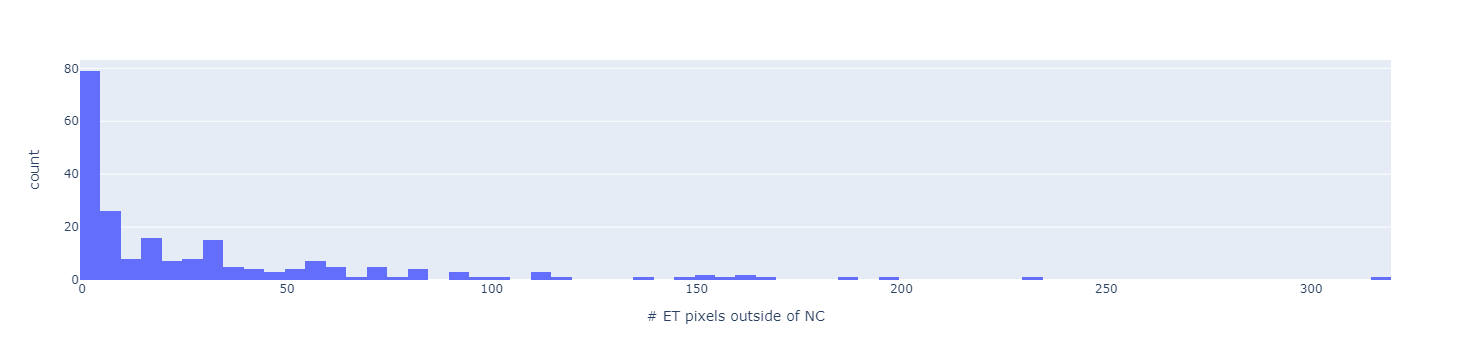

In [116]:
px.histogram(enhancing_df, x="ET_outside", nbins=150, labels={"ET_outside": "# ET pixels outside of NC"})